# LSTM Modeling

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import os
import keras

os.environ["KERAS_BACKEND"] = "torch"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

import sys
sys.path.append('../src')  
import utils as util

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
tensor([1.], device='mps:0')
utils OK


## Load Configuration File

In [2]:
config = util.load_config()

## Read Data

In [3]:
target_col = 'pm1'
sensor_data = 'sensor_data_3'

data_path_pkl = '../' + config['train_test_data']['directory'] + config['train_test_data']['file_name_pkl']  

df = util.load_data_pickle(data_path_pkl)
df = df[sensor_data][[target_col]]

df.head()

,pm1
datetime,
2024-07-02 15:00:00,62.666667
2024-07-02 16:00:00,54.083333
2024-07-02 17:00:00,43.700000
2024-07-02 18:00:00,43.375000
2024-07-02 19:00:00,47.504202


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2024-07-02 15:00:00 to 2024-07-05 14:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm1     72 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


## Preprocessing

### Splitting Data

In [5]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train_data, test_data = df[:train_size], df[train_size:]

In [6]:
dataset_train = train_data[target_col].values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data[target_col].values
dataset_test = np.reshape(dataset_test, (-1,1))

### Normalization

In [7]:
scaler = StandardScaler()

scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

### Create Time Series Dataset

In [8]:
time_step_train = 20
time_step_test = 15

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step])
        Y.append(dataset[i+1:i+time_step+1])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(scaled_train, time_step_train)
X_test, y_test = create_dataset(scaled_test, time_step_test)

In [9]:
X_train.shape, y_train.shape

((30, 20, 1), (30, 20, 1))

In [10]:
X_test.shape, y_test.shape

((7, 15, 1), (7, 15, 1))

### Convert to Tensor

In [11]:
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

In [12]:
batch_size = 4
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modeling

In [13]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): 
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [14]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
num_epochs = 50

model = LSTMModel(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
train_hist =[]
test_hist =[]

for epoch in range(num_epochs):
    total_loss = 0.0
    
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
    
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
        
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.2044, Test Loss: 0.9179
Epoch [20/50] - Training Loss: 0.1006, Test Loss: 0.5440
Epoch [30/50] - Training Loss: 0.0677, Test Loss: 0.5160
Epoch [40/50] - Training Loss: 0.0549, Test Loss: 0.6000
Epoch [50/50] - Training Loss: 0.0485, Test Loss: 0.6198


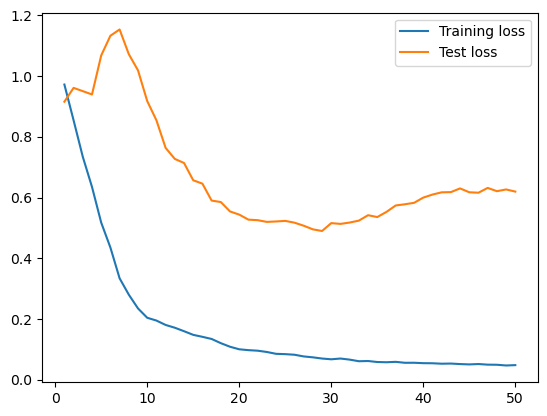

In [16]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

## Prediction

In [17]:

data = df[target_col].values
data = np.reshape(data, (-1,1))
data = scaler.transform(data)
new_df = df.reset_index()
dates = new_df['datetime'].values

seq_length = 50
sequences = []
for i in range(len(data) - seq_length):
    sequences.append(data[i:i+seq_length])
sequences = np.array(sequences)
sequences = torch.tensor(sequences).float().to(device)

model.eval()
with torch.no_grad():
    prediction = model(sequences).cpu().numpy()
prediction = scaler.inverse_transform(np.squeeze(prediction))
prediction = prediction[0]

In [18]:
prediction

array([53.270267 , 48.630943 , 37.554485 , 35.49334  , 42.74134  ,
       43.93847  , 44.520065 , 39.881733 , 34.335056 , 45.582256 ,
       47.56468  , 54.35435  , 60.560844 , 55.340076 , 54.26532  ,
       48.7791   , 36.67327  , 10.365243 , -4.9480057,  6.3213406,
        8.684739 ,  7.898425 ,  8.0751915,  8.42859  ,  8.531041 ,
       10.73745  , 19.246233 ,  8.153256 , 12.478873 , 12.864456 ,
        8.259977 ,  9.198635 ,  9.328923 , 17.364584 , 23.436876 ,
       44.063004 , 37.110634 , 31.912493 , 27.937984 , 33.237114 ,
       42.147255 , 32.428978 , 15.918068 , 14.285463 ,  9.438655 ,
        8.792326 ,  4.9562874,  6.554495 ,  6.683033 ,  8.317407 ],
      dtype=float32)

### Plotting Prediction Result

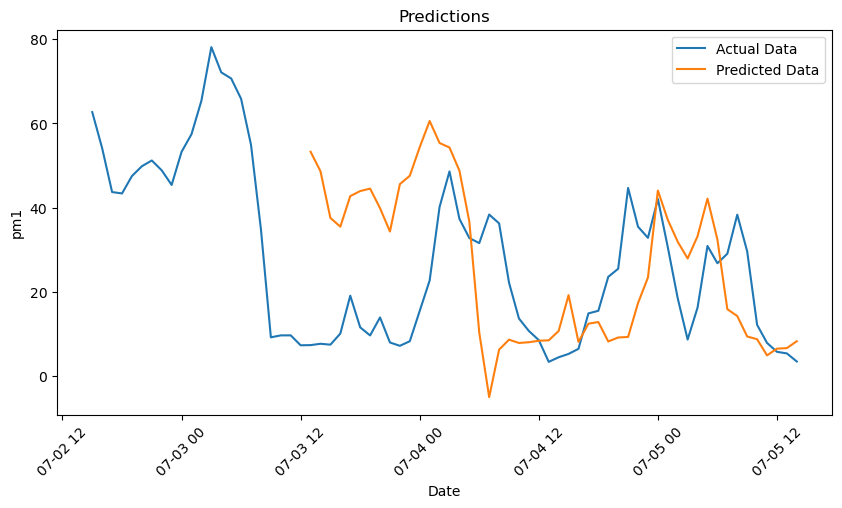

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(dates, df[target_col].values, label='Actual Data')
plt.plot(dates[len(dates) - len(prediction):], prediction, label='Predicted Data')
plt.title(f'Predictions')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Save Model

In [20]:
torch.save(model.state_dict(), f'../models/{sensor_data}_{target_col}_lstm_model.pth')